In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input


from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

#!pip install livelossplot
#from livelossplot import PlotLossesKeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/code')

100%|██████████| 80.9M/80.9M [00:06<00:00, 12.3MB/s]


In [22]:
dataset_path = r'/content/game-of-deep-learning-ship-datasets'
train_path = os.path.join(dataset_path, 'train')
images_path = os.path.join(train_path, 'images')
test_csv = os.path.join(dataset_path, 'test_ApKoW4T.csv')
train_csv = os.path.join(train_path, 'train.csv')

test_df = pd.read_csv(test_csv)
train_df = pd.read_csv(train_csv)

num_test_img = len(test_df)
num_train_img = len(train_df)

print(f'Total Number of test images: {num_test_img}')
print(f'Total Number of train images: {num_train_img}')

Total Number of test images: 2680
Total Number of train images: 6252


In [6]:
main_path = "/content/game-of-deep-learning-ship-datasets/train/images/"
main_df = pd.read_csv(r'/content/game-of-deep-learning-ship-datasets/train/train.csv')
paths = os.listdir(main_path)
main_df['path'] = main_path + main_df['image']

categories = list(main_df['category'])
categorys = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}


In [23]:
classes = []
for category in categories:
    classes.append(categorys[category])


main_df['classes'] = classes
test_df = pd.read_csv(r'/content/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
test_df['path'] = main_path + test_df['image']

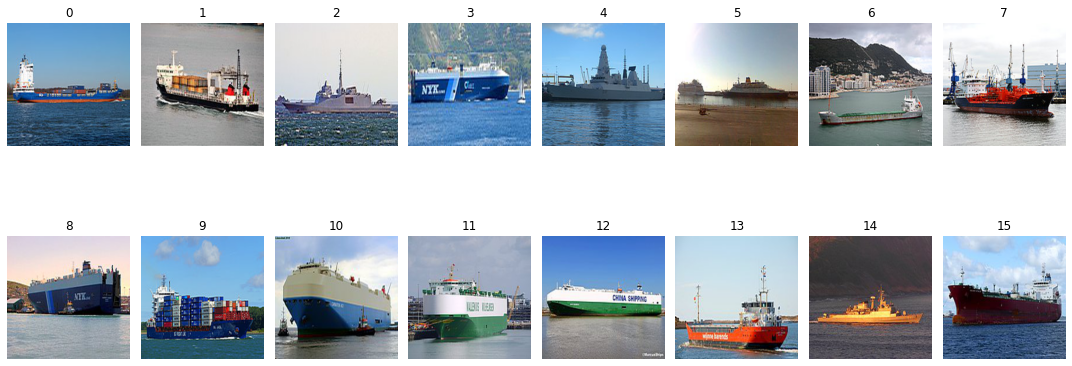

In [25]:
plt.figure(figsize = (15,12))
for idx,image_path in enumerate(main_df['path']):
    if idx==16:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

In [13]:
widths, heights = [], []

for path in tqdm(main_df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
main_df["width"] = widths
main_df["height"] = heights
main_df["dimension"] = main_df["width"] * main_df["height"]

100%|██████████| 6252/6252 [00:00<00:00, 10721.37it/s]


In [14]:
main_df.sort_values('width').head(84)

,image,category,path,classes,width,height,dimension
2766,2833376.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,91,158,14378
3182,2825824.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,96,158,15168
3186,1124952.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,100,158,15800
2732,2855931.jpg,5,/content/game-of-deep-learning-ship-datasets/t...,Tankers,105,158,16590
1576,914599.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,105,158,16590
...,...,...,...,...,...,...,...
3295,1923069.jpg,4,/content/game-of-deep-learning-ship-datasets/t...,Cruise,192,158,30336
1613,2809866.jpg,2,/content/game-of-deep-learning-ship-datasets/t...,Military,192,158,30336
2840,2849133.jpg,3,/content/game-of-deep-learning-ship-datasets/t...,Carrier,192,158,30336
3672,2777434.jpg,4,/content/game-of-deep-learning-ship-datasets/t...,Cruise,192,158,30336


In [15]:
X, y = main_df[['path', 'classes']], main_df['classes']

In [39]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.8/0.9, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (625, 2)
y_train shape:  (625,)
X_val shape  :  (5001, 2)
y_val shape  :  (5001,)
X_test shape :  (626, 2)
y_test shape :  (626,)


In [40]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
)

Found 625 validated image filenames belonging to 5 classes.
Found 5001 validated image filenames belonging to 5 classes.
Found 626 validated image filenames belonging to 5 classes.


In [41]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 100
epochs = 15

# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(192,192,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model_vgg1 = Model(inputs=base.input, outputs=head)

# Compiling the model
model_vgg1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [42]:
# Fitting the model with train and validation augmented datasets.
history = model_vgg1.fit(train_generator_vgg,
                        validation_data=val_generator_vgg,
                        #steps_per_epoch=training_data_size // batch_size,
                        #class_weight=weights,
                        # callbacks=callbacks_list, 
                        #validation_steps=validation_data_size // batch_size,
                        epochs=2)

Epoch 1/2
20/20 [==============================] - 70s 3s/step - loss: 1.4880 - accuracy: 0.3904 - val_loss: 1.4063 - val_accuracy: 0.4155
Epoch 2/2
20/20 [==============================] - 62s 3s/step - loss: 0.8895 - accuracy: 0.7424 - val_loss: 1.0539 - val_accuracy: 0.6205


20/20 [==============================] - 7s 335ms/step


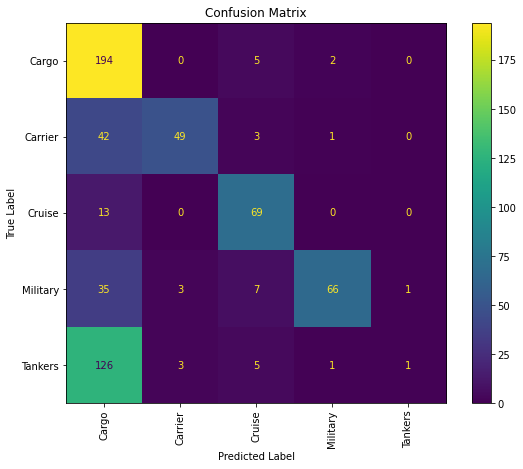


 Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.97      0.64       201
           1       0.89      0.52      0.65        95
           2       0.78      0.84      0.81        82
           3       0.94      0.59      0.73       112
           4       0.50      0.01      0.01       136

    accuracy                           0.61       626
   macro avg       0.72      0.58      0.57       626
weighted avg       0.67      0.61      0.54       626


Accuracy: 0.0

Cohen Kappa Score is  0.46466272664637787


In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Predicting labels from X_test data
y_pred = model_vgg1.predict(test_generator_vgg)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
plt.rcParams["figure.figsize"] = (9, 7)
from sklearn.preprocessing import LabelEncoder

ship_labels = ['Cargo','Carrier','Cruise','Military','Tankers']

# Create the confusion matrix
conf_mat = confusion_matrix(test_generator_vgg.classes, y_pred_classes)
cmd_obj = ConfusionMatrixDisplay(conf_mat, display_labels=ship_labels)

cmd_obj.plot()

cmd_obj.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted Label', 
                ylabel='True Label')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

plt.show()

print('\n Classification Report:\n',classification_report(test_generator_vgg.classes, y_pred_classes))
from sklearn import metrics
print("\nAccuracy:",metrics.accuracy_score(y_test, y_pred_classes))
from sklearn.metrics import cohen_kappa_score
 
#calculate Cohen's Kappa
print('\nCohen Kappa Score is ',cohen_kappa_score(test_generator_vgg.labels, y_pred_classes))

In [56]:
print('\nF1 Score is',f1_score(test_generator_vgg.labels, y_pred_classes, average='weighted'))


F1 Score is 0.5217277222756557


In [74]:
test_size1 = [0.8,0.7]#,0.6,0.5,0.4,0.3,0.2]
from keras.models import load_model
from sklearn.metrics import f1_score
kappa_score = {}
saved_models = ['model10.h5','model20.h5']#,'model30.h5','model40.h5','model50.h5','model60.h5','model70.h5']
X_train = {}
X_val = {}
y_train= {}
y_val = {}
for i in range(2):
  X_train[i], X_val[i], y_train[i], y_val[i] = train_test_split(X_data, y_data, test_size= test_size1[i]/0.9, random_state=42)
  
  train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train[i],  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        )
  val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val[i],  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        )
  base = Xception(include_top=False, weights='imagenet', input_shape=(192,192,3))
  x = base.output
  x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
  head = Dense(5, activation='softmax')(x)
  model_vgg1 = Model(inputs=base.input, outputs=head)
  model_vgg1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  history = model_vgg1.fit(train_generator_vgg,
                        validation_data=val_generator_vgg,
                        #steps_per_epoch=training_data_size // batch_size,
                        #class_weight=weights,
                        # callbacks=callbacks_list, 
                        #validation_steps=validation_data_size // batch_size,
                        epochs=1)
  y_pred = model_vgg1.predict(test_generator_vgg)

  y_pred_classes = np.argmax(y_pred, axis = 1)
  print("\nAccuracy:",metrics.accuracy_score(test_generator_vgg.labels, y_pred_classes))
  print('\nF1 Score is',f1_score(test_generator_vgg.labels, y_pred_classes, average='weighted'))
  kappa_score[i] = cohen_kappa_score(test_generator_vgg.labels, y_pred_classes)
  print('\nCohen Kappa Score is\n ',kappa_score[i])
  model_vgg1.save(saved_models[i])

Found 625 validated image filenames belonging to 5 classes.
Found 5001 validated image filenames belonging to 5 classes.
20/20 [==============================] - 8s 349ms/step

Accuracy: 0.4169329073482428

F1 Score is 0.3185580695830231

Cohen Kappa Score is
  0.1666636273783949
Found 1250 validated image filenames belonging to 5 classes.
Found 4376 validated image filenames belonging to 5 classes.
20/20 [==============================] - 8s 344ms/step

Accuracy: 0.6150159744408946

F1 Score is 0.5675519814593197

Cohen Kappa Score is
  0.47907545267461293


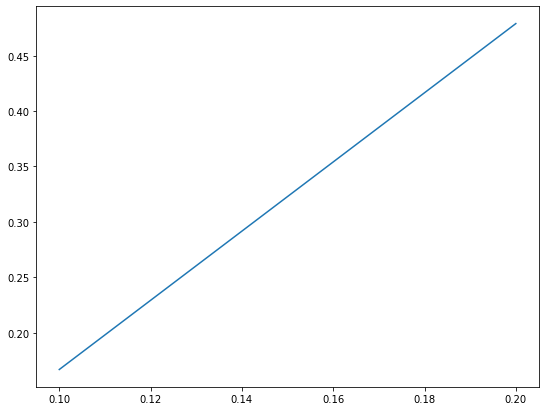

In [75]:
train_data_per = [0.1,0.2]
kappa_score = np.array(list(kappa_score.items())).T[1]
plt.plot(train_data_per,kappa_score)

array([0.43872233, 0.67106021])

[(0, 0.438722331185206), (1, 0.6710602146600764)]